# The clinician impact and financial cost to the NHS of litigation over pregabalin

## The impact of the NHS England letter on prescribers in the NHS

In February 2015 an English Court ordered NHS England to write to all prescribers and pharmacists in England, advising that when pregabalin was prescribed for neuropathic pain (thought to be appoximately 70% of all prescriptions) the brand Lyrica should be prescribed, rather than the generic drug.

In order to assess the impact, we need to calculate whether GPs followed this guidance.

All data used in this Jupyter notebook is from OpenPrescribing.net's Google BigQuery database.  

In order to reduce costs and server overheads, a BigQuery table was created containing all prescribing data from the main prescribing database for the eight strengths of pregabalin capsules available in England, using partial BNF codes to find all brands and generic prescriptions:

* 0408010AE%AA - pregabalin 25mg capsules
* 0408010AE%AB - pregabalin 50mg capsules
* 0408010AE%AC - pregabalin 75mg capsules
* 0408010AE%AD - pregabalin 100mg capsules
* 0408010AE%AE - pregabalin 150mg capsules
* 0408010AE%AF - pregabalin 200mg capsules
* 0408010AE%AI - pregabalin 225mg capsules
* 0408010AE%AG - pregabalin 300mg capsules


### Obtaining data from BigQuery

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import  DateFormatter
%matplotlib inline

In [2]:
projectid = "ebmdatalab"
#obtain overall data for all CCG prescribing for pregabalin capsules
overall_df = pd.read_gbq("""
SELECT
  FORMAT_TIMESTAMP("%B %Y", pregabalin.month) as month_string,
  pregabalin.month as period,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2)='BB' THEN items
      ELSE 0 END) AS lyrica_items,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2)='AA' THEN items
      ELSE 0 END) AS generic_items,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2) NOT IN ('AA', 'BB')THEN items
      ELSE 0 END) AS other_brand_items
FROM
ebmdatalab.richard.pregabalin_data AS pregabalin
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  pregabalin.pct=ccg.code
WHERE
ccg.org_type = 'CCG'
and pregabalin.month >='2013-04-01 00:00:00'
GROUP BY
  period, month_string
ORDER BY
  period
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_4uugyrwNpwNCoUWnOWR96CJF9crZ
Query running...
Query done.
Processed: 177.6 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 100% done. Elapsed 10.76 s.
Got 55 rows.

Total time taken 10.8 s.
Finished at 2018-06-08 13:50:54.


In [3]:
#obtain overall data for prescribing for pregabalin capsules at CCG level
ccg_df = pd.read_gbq("""
SELECT
  pregabalin.month as period,
  pregabalin.pct,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2)='BB' THEN items
      ELSE 0 END) AS lyrica_items,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2)='AA' THEN items
      ELSE 0 END) AS generic_items,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2) NOT IN ('AA', 'BB')THEN items
      ELSE 0 END) AS other_brand_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(pregabalin.bnf_code,10,2)='BB' THEN items
        ELSE 0 END), SUM(items)) AS lyrica_percent,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(pregabalin.bnf_code,10,2) NOT IN ('AA', 'BB')THEN items
        ELSE 0 END), SUM(items)) AS other_brands_percent
FROM
ebmdatalab.richard.pregabalin_data AS pregabalin
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  pregabalin.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
 and pregabalin.month >='2013-04-01 00:00:00'
GROUP BY
  period,
  pct
ORDER BY
  period,
  pct
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_6ilqcDI7rMaNdSY4wp1i3AT6NYs4
Query running...
Query done.
Processed: 177.6 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 100% done. Elapsed 10.01 s.
Got 11438 rows.

Total time taken 11.25 s.
Finished at 2018-06-08 13:51:07.


In [4]:
#obtain overall data for prescribing for pregabalin capsules at practice level where practices with list size of => 1000

practice_df = pd.read_gbq("""
SELECT
  pregabalin.month as period,
  pregabalin.practice,
  SUM(CASE
      WHEN SUBSTR(pregabalin.bnf_code,10,2)='BB' THEN items
      ELSE 0 END) AS lyrica_items,
  SUM(CASE
      WHEN SUBSTR(  pregabalin.bnf_code,10,2)='AA' THEN items
      ELSE 0 END) AS generic_items,
  SUM(CASE
      WHEN SUBSTR(  pregabalin.bnf_code,10,2) NOT IN ('AA', 'BB')THEN items
      ELSE 0 END) AS other_brand_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(  pregabalin.bnf_code,10,2)='BB' THEN items
        ELSE 0 END), SUM(items)) AS lyrica_percent,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(  pregabalin.bnf_code,10,2) NOT IN ('AA', 'BB')THEN items
        ELSE 0 END), SUM(items)) AS other_brands_percent
FROM
ebmdatalab.richard.pregabalin_data AS pregabalin
  INNER JOIN
  ebmdatalab.hscic.practice_statistics AS listsize
ON
    pregabalin.practice=listsize.practice
  AND   pregabalin.month=listsize.month
WHERE
listsize.total_list_size >=1000
and pregabalin.month >='2013-04-01 00:00:00'
GROUP BY
  period,
  practice
ORDER BY
  period,
  practice
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_sCfn98LtiyTpZ4Qumfir5J0YyF_d
Query running...
  Elapsed 11.17 s. Waiting...
Query done.
Processed: 203.3 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 10% done. Elapsed 24.08 s.
  Got page: 2; 21% done. Elapsed 29.35 s.
  Got page: 3; 31% done. Elapsed 34.5 s.
  Got page: 4; 42% done. Elapsed 39.26 s.
  Got page: 5; 52% done. Elapsed 46.06 s.
  Got page: 6; 63% done. Elapsed 53.18 s.
  Got page: 7; 73% done. Elapsed 59.69 s.
  Got page: 8; 84% done. Elapsed 67.64 s.
  Got page: 9; 94% done. Elapsed 75.21 s.
  Got page: 10; 100% done. Elapsed 79.92 s.
Got 418895 rows.

Total time taken 120.39 s.
Finished at 2018-06-08 13:53:08.


### Create stacked bar chart for overall prescribing of Lyrica, generic and other brands in NHS in England

In [5]:
#Create additional columns for bar stacks
overall_df['lyrica_and_generic']=overall_df['lyrica_items']+overall_df['generic_items']
overall_df['all_items']=overall_df['lyrica_items']+overall_df['generic_items']+overall_df['other_brand_items']

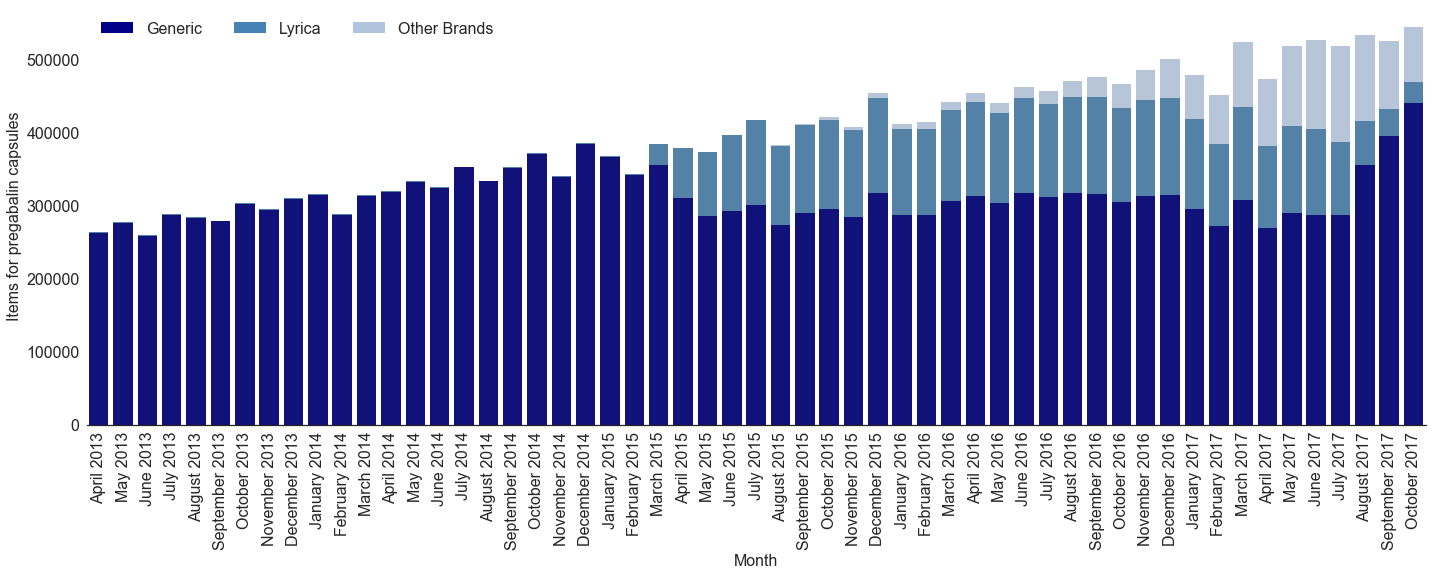

In [6]:
#Create stacked graph in Seaborn, using overlayed plots
#setup style and size
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})
#Plot 1 - "All items"  - will show "other brands" in final plot
ax = sns.barplot(x="month_string", y="all_items",data=overall_df,color = "lightsteelblue")
#Plot 2 - overlay - "generic_and_lyrica" series  - will show Lyrica in final plot
middle_plot = sns.barplot(x="month_string", y="lyrica_and_generic",data=overall_df, color = "steelblue")
#Plot 3 - overlay - "generic" series - shows generic in final plot
bottom_plot = sns.barplot(x="month_string", y="generic_items",data=overall_df, color = "darkblue")

#create legend
topbar = plt.Rectangle((0,0),1,1,fc="lightsteelblue", edgecolor = 'none')
middlebar = plt.Rectangle((0,0),1,1,fc="steelblue", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='darkblue',  edgecolor = 'none')
l = plt.legend([bottombar, middlebar, topbar], ['Generic', 'Lyrica', 'Other Brands'], loc=0, ncol = 3, prop={'size':16})
l.draw_frame(False)

#axes formatting
sns.despine(left=True)
plt.xticks(rotation=90)
bottom_plot.set_ylabel("Items for pregabalin capsules")
bottom_plot.set_xlabel("Month")
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
plt.subplots_adjust(bottom = 0.3)
plt.savefig('Figure 1.png', format='png', dpi=300)

### Create timeseries for CCGs and practice deciles of percentage of pregabalin as Lyrica

In [7]:
import datetime
#create deciles for practices
x = np.arange(0.1, 1, 0.1)
practice_deciles = practice_df.groupby('period')['lyrica_percent'].quantile(x)
practice_deciles_df=pd.DataFrame(practice_deciles)
practice_deciles_df=practice_deciles_df.reset_index()
# create integer range of percentiles as integers are better for  charts
practice_deciles_df["index"] = (practice_deciles_df.level_1*10).map(int)
practice_deciles_df['period'] = practice_deciles_df['period'].astype(str)
# set format for dates:
practice_deciles_df['period'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in practice_deciles_df['period']]

#create deciles for CCGs
x = np.arange(0.1, 1, 0.1)
ccg_deciles = ccg_df.groupby('period')['lyrica_percent'].quantile(x)
ccg_deciles_df=pd.DataFrame(ccg_deciles)
ccg_deciles_df=ccg_deciles_df.reset_index()
# create integer range of percentiles as integers are better for  charts
ccg_deciles_df["index"] = (ccg_deciles_df.level_1*10).map(int)
ccg_deciles_df['period'] = ccg_deciles_df['period'].astype(str)
# set format for dates:
ccg_deciles_df['period'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in ccg_deciles_df['period']]

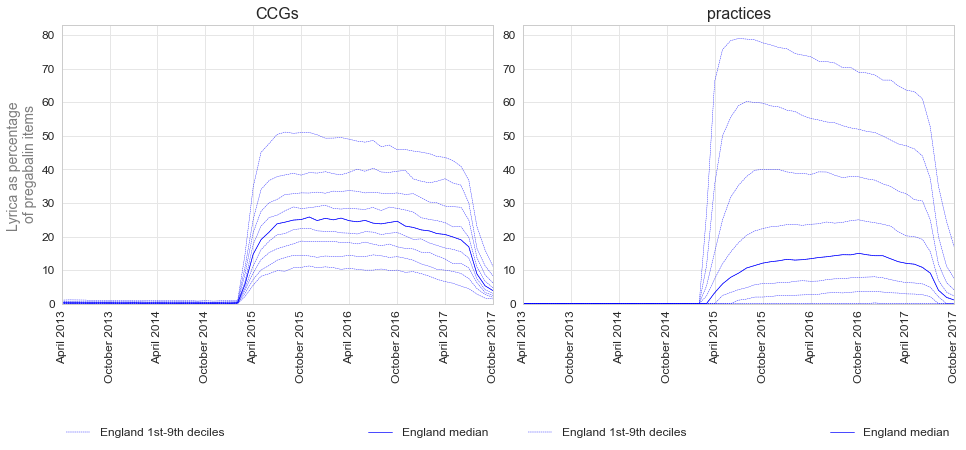

In [8]:
# Plot time series charts of deciles
import matplotlib.pyplot as plt
import datetime
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style("whitegrid",{'grid.color': '.9'})

fig = plt.figure(figsize=(16,6.666)) 
gs = gridspec.GridSpec(1,2)  # grid layout for subplots

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,ccg_deciles_df,0,0,'CCGs'), (1,practice_deciles_df,0,1,'practices')]

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]],sharey=ax)  # position of subplot in grid using coordinates listed in s
    for decile in range(1,10):   # plot each decile line
        data = i[1].loc[(i[1]['index']==decile)]
        if decile == 5:
            ax.plot(data["period"],100*data['lyrica_percent'],'b-',linewidth=0.7, label='England median')
        if decile == 1:
            ax.plot(data["period"],100*data['lyrica_percent'],'b--',linewidth=0.4,label='England 1st-9th deciles')     
        else:
            ax.plot(data["period"],100*data['lyrica_percent'],'b--',linewidth=0.4, label='_nolegend_') 
    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Lyrica as percentage \nof pregabalin items', size =14, alpha=0.6)
    ax.set_title(i[4],size = 16)
    ax.set_ylim([0, 100*i[1]['lyrica_percent'].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([i[1]['period'].min(), i[1]['period'].max()]) # set x axis range as full date range
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
    ax.legend(bbox_to_anchor=(0., -.5, 1., .102), loc=8,
        ncol=2, mode="expand", fontsize=12, borderaxespad=0.)
    
plt.subplots_adjust(wspace = 0.07,hspace = 0.15, bottom = 0.3)
plt.savefig('Figure 2.png', format='png', dpi=300)
plt.show()

### Examples of unusual CCG patterns

In [9]:
#create df for Brent CCG (07P)
df_07P = ccg_df.filter(['period','pct','lyrica_percent'], axis=1)
df_07P = df_07P[df_07P['pct']=='07P']
df_07P = df_07P.reset_index()

#create df for Ashford CCG (09C)
df_09C = ccg_df.filter(['period','pct','lyrica_percent'], axis=1)
df_09C = df_09C[df_09C['pct']=='09C']
df_09C = df_09C.reset_index()

#create df for South Kent Coast CCG (10A)
df_10A = ccg_df.filter(['period','pct','lyrica_percent'], axis=1)
df_10A = df_10A[df_10A['pct']=='10A']
df_10A = df_10A.reset_index()

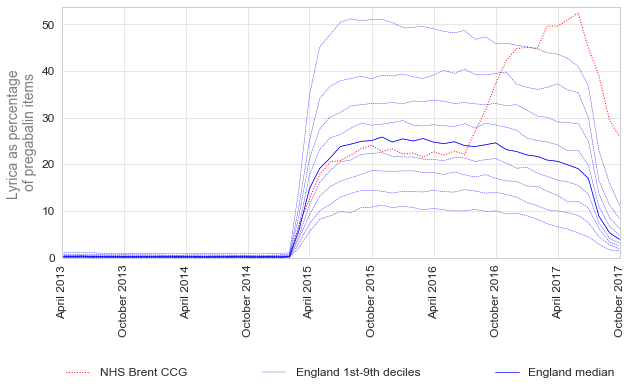

In [10]:
# Plot time series charts of deciles for 07P

sns.set_style("whitegrid",{'grid.color': '.9'})

fig = plt.figure(figsize=(10,6)) 
gs = gridspec.GridSpec(1,1)  # grid layout for subplots

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,ccg_deciles_df,0,0,'NHS Brent CCG')]

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]],sharey=ax)  # position of subplot in grid using coordinates listed in s
    ax.plot(data["period"],100*df_07P['lyrica_percent'],'r:',linewidth=1, label='NHS Brent CCG')
    for decile in range(1,10):   # plot each decile line
        data = i[1].loc[(i[1]['index']==decile)]
        if decile == 5:
            ax.plot(data["period"],100*data['lyrica_percent'],'b-',linewidth=0.7, label='England median')
        if decile == 1:
            ax.plot(data["period"],100*data['lyrica_percent'],'b--',linewidth=0.4,label='England 1st-9th deciles')     
        else:
            ax.plot(data["period"],100*data['lyrica_percent'],'b--',linewidth=0.4, label='_nolegend_') 
            

    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Lyrica as percentage \nof pregabalin items', size =14, alpha=0.6)
#ax.set_title(i[4],size = 18)
    ax.set_ylim([0, 100*i[1]['lyrica_percent'].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([i[1]['period'].min(), i[1]['period'].max()]) # set x axis range as full date range
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
    ax.legend(bbox_to_anchor=(0., -.5, 1., .102), loc=8,
       ncol=3, mode="expand", fontsize=12, borderaxespad=0.)
    
plt.subplots_adjust(wspace = 0.07,hspace = 0.15, bottom = 0.3)
plt.savefig('Figure 3.png', format='png', dpi=300)
plt.show()

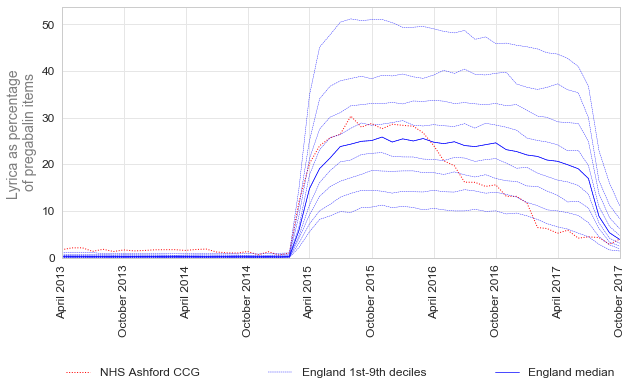

In [11]:
# Plot time series charts of deciles for 09C

sns.set_style("whitegrid",{'grid.color': '.9'})

fig = plt.figure(figsize=(10,6)) 
gs = gridspec.GridSpec(1,1)  # grid layout for subplots

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,ccg_deciles_df,0,0,'NHS Ashford CCG')]

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]],sharey=ax)  # position of subplot in grid using coordinates listed in s
    ax.plot(data["period"],100*df_09C['lyrica_percent'],'r:',linewidth=1, label='NHS Ashford CCG')
    for decile in range(1,10):   # plot each decile line
        data = i[1].loc[(i[1]['index']==decile)]
        if decile == 5:
            ax.plot(data["period"],100*data['lyrica_percent'],'b-',linewidth=0.7, label='England median')
        if decile == 1:
            ax.plot(data["period"],100*data['lyrica_percent'],'b--',linewidth=0.4,label='England 1st-9th deciles')     
        else:
            ax.plot(data["period"],100*data['lyrica_percent'],'b--',linewidth=0.4, label='_nolegend_') 
            

    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Lyrica as percentage \nof pregabalin items', size =14, alpha=0.6)
#ax.set_title(i[4],size = 18)
    ax.set_ylim([0, 100*i[1]['lyrica_percent'].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([i[1]['period'].min(), i[1]['period'].max()]) # set x axis range as full date range
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
    ax.legend(bbox_to_anchor=(0., -.5, 1., .102), loc=8,
       ncol=3, mode="expand", fontsize=12, borderaxespad=0.)
    
plt.subplots_adjust(wspace = 0.07,hspace = 0.15, bottom = 0.3)
plt.savefig('Figure 4.png', format='png', dpi=300)
plt.show()

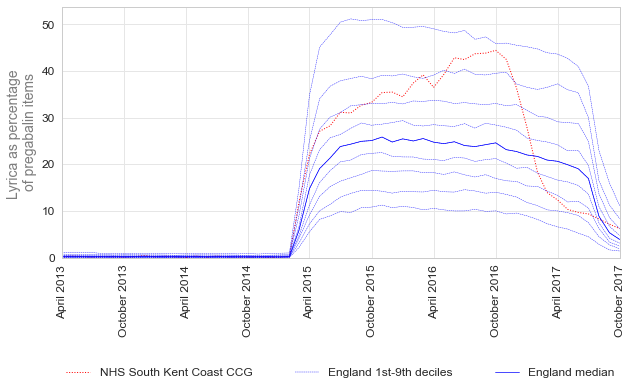

In [17]:
# Plot time series charts of deciles for 10A

sns.set_style("whitegrid",{'grid.color': '.9'})

fig = plt.figure(figsize=(10,6)) 
gs = gridspec.GridSpec(1,1)  # grid layout for subplots

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,ccg_deciles_df,0,0,'NHS South Kent Coast CCG')]

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]],sharey=ax)  # position of subplot in grid using coordinates listed in s
    ax.plot(data["period"],100*df_10A['lyrica_percent'],'r:',linewidth=1, label='NHS South Kent Coast CCG')
    for decile in range(1,10):   # plot each decile line
        data = i[1].loc[(i[1]['index']==decile)]
        if decile == 5:
            ax.plot(data["period"],100*data['lyrica_percent'],'b-',linewidth=0.7, label='England median')
        if decile == 1:
            ax.plot(data["period"],100*data['lyrica_percent'],'b--',linewidth=0.4,label='England 1st-9th deciles')     
        else:
            ax.plot(data["period"],100*data['lyrica_percent'],'b--',linewidth=0.4, label='_nolegend_') 
            

    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Lyrica as percentage \nof pregabalin items', size =14, alpha=0.6)
#ax.set_title(i[4],size = 18)
    ax.set_ylim([0, 100*i[1]['lyrica_percent'].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([i[1]['period'].min(), i[1]['period'].max()]) # set x axis range as full date range
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
    ax.legend(bbox_to_anchor=(0., -.5, 1., .102), loc=8,
       ncol=3, mode="expand", fontsize=12, borderaxespad=0.)
    
plt.subplots_adjust(wspace = 0.07,hspace = 0.15, bottom = 0.3)
plt.savefig('Figure 5.png', format='png', dpi=300)
plt.show()

## Assessing the financial impact of possible Lyrica patent invalidity

In September 2015 the patent claim for Lyrica for neuropathic pain was found to be invalid by a UK Court. This was upheld on appeal in October 2016, and is due to be heard at the UK Supreme Court in early 2018.

If the Supreme Court agrees with the ruling that the neuropathic pain patent is invalid, then it could be argued that the NHS has continued to pay for the cost of the patent product (Lyrica) rather than a cheaper generic version.

We can calculate the impact of this from October 2015,the first full month after the date of the original ruling.

As the price of generic pregabalin was fixed in the Drug Tariff as Lyrica until August 2017 (the month after the disputed patent ended), it did not matter, from a cost perspective, whether generic or branded pregabalin was prescribed up until the tariff changed

### Assumptions made

1. Before the NHS England letter to GPs, pregabalin prescribing was approximately 99.5% generic.  We have assumed that prescribing of pregabalin, including Lyrica and all branded generics would revert to generic prescribing.
2. If pregabalin had been fully available generically before August 2017, the Drug Tariff prices would have been the same in those earlier months than at August 2017
3. The data calculated is for all FP10 data for England, including any prescribing from other providers which would have been charged at the same reimbursement rate as primary care.
4. The calculations include a reduction of the mean "National Average Discount Percentage", which is what the NHS paid, as opposed to the NHS list price.  This was calculated as 7.49%

### Obtaining data from BigQuery

In [13]:
pregabalin_df = pd.read_gbq("""
SELECT
  month AS period,
  (CASE SUBSTR(bnf_code,14,2)
      WHEN 'AA' THEN '25mg capsules'
      WHEN 'AB' THEN '50mg capsules'
      WHEN 'AC' THEN '75mg capsules'
      WHEN 'AD' THEN '100mg capsules'
      WHEN 'AE' THEN '150mg capsules'
      WHEN 'AF' THEN '200mg capsules'
      WHEN 'AI' THEN '225mg capsules'
      WHEN 'AG' THEN '300mg capsules'
      ELSE NULL END) AS strength,
  SUM(quantity) AS quantity,
  SUM(net_cost) AS nic
FROM
ebmdatalab.richard.pregabalin_data
GROUP BY
  period,
  strength
ORDER BY
  period
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_xgNUeLXhGYXnagwvUGXhdNtcoaSE
Query running...
Query done.
Processed: 191.6 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 100% done. Elapsed 7.22 s.
Got 696 rows.

Total time taken 7.34 s.
Finished at 2018-06-08 13:56:28.


### Calculate the estimated impact per month

In [14]:
#create period as index
pregabalin_df.index = pregabalin_df['period']
del pregabalin_df['period']

#define dt_ppu to calculate cost per capsule for each strength as per cost and pack size in August 2017 Drug Tariff
def dt_ppu(c):
    if c['strength'] == '25mg capsules':
        return 1.87/56
    if c['strength'] == '50mg capsules':
        return 2.28/84
    if c['strength'] == '75mg capsules':
        return 2.03/56
    if c['strength'] == '100mg capsules':
        return 2.98/84
    if c['strength'] == '150mg capsules':
        return 2.29/56
    if c['strength'] == '200mg capsules':
        return 3.60/84
    if c['strength'] == '225mg capsules':
        return 3.11/56
    if c['strength'] == '300mg capsules':
        return 4.17/56
    else:
        return 0

#apply cost per capsule to dataframe
pregabalin_df['dt_ppu'] = pregabalin_df.apply(dt_ppu, axis=1)
#calculate the estimated NIC @ August 2017 DT prices by multiplying quantity of capsule by price per unit
pregabalin_df['dt_nic']=pregabalin_df['quantity']*pregabalin_df['dt_ppu']
#calculate the difference in actual and estimated NIC
pregabalin_df['nic_difference']=(pregabalin_df['nic']-pregabalin_df['dt_nic'])
#calculate the estimated actual cost difference by applying 7.49% discount
pregabalin_df['act_cost_difference']=(pregabalin_df['nic_difference']*.9251)

### Estimated impact from October 2015 - July 2017

In [15]:
#create new dataframe by filtering dates
sep15_df=pregabalin_df.loc['2015-10-01':'2017-07-01']
sep15_df.is_copy = None
#groupby each capsule strength
sep15_gp_df=sep15_df.groupby(['strength'])['nic','dt_nic','nic_difference','act_cost_difference'].sum()
#create totals for 100% and 99.5%
sep15_gp_df.loc['Total']=sep15_gp_df.sum(axis=0)
sep15_gp_df.loc['Total at 99.5%']=.995*sep15_gp_df.loc['Total']
#format numbers as currency
sep15_gp_df['nic'] = sep15_gp_df['nic'].map('£{:,.0f}'.format) 
sep15_gp_df['dt_nic'] = sep15_gp_df['dt_nic'].map('£{:,.0f}'.format)
sep15_gp_df['nic_difference'] = sep15_gp_df['nic_difference'].map('£{:,.0f}'.format)
sep15_gp_df['act_cost_difference'] = sep15_gp_df['act_cost_difference'].map('£{:,.0f}'.format) 
#tidy up column names for print
sep15_gp_df.rename(columns={'nic':'NIC', 'dt_nic':'Estimated NIC at August 2017 Drug Tariff', 'nic_difference':'Difference in NIC', 'act_cost_difference':'Difference in Actual Cost'})

,NIC,Estimated NIC at August 2017 Drug Tariff,Difference in NIC,Difference in Actual Cost
strength,,,,
100mg capsules,"£65,935,836","£2,104,684","£63,831,151","£59,050,198"
150mg capsules,"£110,670,782","£4,070,097","£106,600,685","£98,616,294"
200mg capsules,"£34,042,634","£1,318,460","£32,724,174","£30,273,133"
225mg capsules,"£12,959,623","£653,483","£12,306,141","£11,384,411"
25mg capsules,"£54,732,394","£1,651,112","£53,081,282","£49,105,494"
300mg capsules,"£89,364,123","£6,008,264","£83,355,859","£77,112,505"
50mg capsules,"£78,998,270","£1,930,269","£77,068,001","£71,295,608"
75mg capsules,"£120,226,538","£3,917,799","£116,308,739","£107,597,214"
Total,"£566,930,199","£21,654,167","£545,276,032","£504,434,857"


In [16]:
# construct a mask of all lyrica practices
lyricapre = (pre_practice_df.lyrica_items > 0)
lyricapost = (post_practice_df.lyrica_items > 0)
post_table_df=pd.DataFrame(
    [['Total number of practices',np.size(pre_practice_df,0),np.size(post_practice_df,0)],
     ['Number of practices prescribing pregabalin',np.count_nonzero(pre_practice_df.all_items,0),np.count_nonzero(post_practice_df.all_items,0)],
     ['Number of practices prescribing lyrica',np.count_nonzero(pre_practice_df.lyrica_items,0),np.count_nonzero(post_practice_df.lyrica_items,0)],
     ['Prescribing of pregabalin as Lyrica in lyrica practices',np.sum(pre_practice_df.lyrica_items[lyricapre]),np.sum(post_practice_df.lyrica_items[lyricapost])]])
    

NameError: name 'pre_practice_df' is not defined

In [ ]:
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)
display(HTML(post_table_df.to_html(header=False,formatters={'wider': '{:,.5f}'.format})))